# Vision Transformers 101

<img src="https://memegenerator.net/img/instances/32071259/transformers-transformers-everywhere.jpg" style="width:40%">

Transformer is a family of neural network architectures that came to computer vision from NLP. Since transformers don't assume that their input has any specific structure, they can learn more general dependencies in data than convolutional neural network architectures. That's why we all like Vision transformers. At the same time, vision transformes are known to be "data hungry" and their training is quite tricky.

Todays we will go through main components of vision transformers and their training procedure. This information will be quite useful for solving the next homework where your task will be to train vision transformer on CIFAR-10.

In [2]:
import torch
from torch import nn

## How to code your transformer

<img src="./vit.png" style="width:50%">

As it was said, vision transformer came from NLP area where typical neural network input is ordered sequence of tokens which are words or word parts. So vision transformer main blocks are:
1. Tokenizer - module that takes images and returns a set of tokens
2. Transformer encoder - the main block of neural network that contains multihead attention, normalization and MLP on tokens.
3. Positional embeddings - a way how to provide information about token orders
4. Classification token - special token whose features is expected to be used for the final class prediction
5. Classification head - MLP that predicts the final class from classificaiton token features

### Tokenizer

Tokenizer should take an image, split it on non-overlapping patches, flatten the patches and apply Linear layer to these vectors. There are many ways how one can implement this, we will do it using Conv2D with stride being equal to kernel_size.

In [3]:
class Tokenizer(nn.Module):
    def __init__(self, input_height, input_width, output_height, output_width,
                 n_input_channels,
                 embedding_dim):
        super(Tokenizer, self).__init__()

        assert input_height % output_height == 0, f"{input_height} should be devided by {output_height}"
        assert input_width % output_width == 0, f"{input_width} should be devided by {output_width}"
        
        kernel_size = input_height // output_height
        assert kernel_size == input_width // output_width

        # YOUR CODE
        self.conv = nn.Conv2d(n_input_channels, embedding_dim, 
                              kernel_size=kernel_size, 
                              stride=kernel_size, 
                              padding=0)

        self.flattener = nn.Flatten(2, 3)

    def forward(self, x):
        x = self.conv(x)
        x = self.flattener(x)
        x = x.transpose(-2, -1)
        return x


In [4]:
tokenizer = Tokenizer(input_height=32, input_width=32, output_height=16, output_width=16, n_input_channels=1,
                      embedding_dim=64)
dummy_batch = torch.zeros((1, 1, 32, 32))
tokenizer_result = tokenizer.forward(dummy_batch)
assert tokenizer_result.shape[1] == 16*16, tokenizer_result.shape

### Transformer encoder

<img src="./transformer_encoder.png" style="width:20%">

Transformer encoder consists of 2 blocks: Multi-Head Attention and MLP, each of each is prepended by layer norm. Let's walk through the separate modules for beggining

#### Multi-head attention

<img src="https://data-science-blog.com/wp-content/uploads/2022/01/mha_img_original.png" style="width:50%">

Attention implements a simple formula: $\text{Attention}(Q,K,V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$.

Multi-head attention is about splitting Q, K, V on several subvectors, appling Attention on each subvector independendly and concating the result.

You can find Multi-Head Attention being implemented in pytorch as `torch.nn.MultiheadAttention`. Check the documentation and pay attention on `dropout` and `batch_first` parameters.

[[paper]](https://arxiv.org/pdf/1706.03762.pdf)

In [5]:
# torch.nn.MultiheadAttention??

#### MLP for Transformer Encoder

MLP for transformer encoder is just a simple two-layer perceptron with GELU as non-linearity. It also uses Dropout after each Linear layer in order to reduce overfitting. Important thing is that size of hidden state on MLP is usually several times bigger than size of MLP input.

In [6]:
def create_mlp(embedding_dim, mlp_size, dropout_rate):
    return nn.Sequential(
        # YOUR CODE: Linear + GELU + Dropout + Linear + Dropout
        nn.Linear(embedding_dim, mlp_size),
        nn.GELU(),
        nn.Dropout1d(dropout_rate),
        nn.Linear(mlp_size, embedding_dim),
        nn.Dropout1d(dropout_rate)
    )

In [7]:
mlp = create_mlp(128, 128 * 2, 0.1)

#### GELU

Hey, wait! What is GELU? One can say that GELU is sort of smooth version of ReLU. Take a look

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-27_at_12.48.44_PM.png" style="width:40%">

More formally, GELU can be defined as $$GELU(x) = x \cdot P(X \le x) = x \cdot \Phi(x) = x \cdot 12 (1 + \text{erf}(\frac{x}{\sqrt{2}}))$$
where $\Phi(x)$ is the standard Gaussian cumulative distribution function.

GELU can also be approximated as $$ GELU(x) = 0.5x(1 + \tanh(\sqrt{\frac{2}{\pi}} (x+ 0.044715x^3)))$$
or $$GELU(x) = x \sigma(1.702x)$$

[[paper]](https://arxiv.org/abs/1606.08415v4)

#### Layer norm

While Batch Normalization is a default normalization layer for convolutional neural networks, in transformers Layer Normalization is used instead. Moreover, Layer Norm is used in NLP-like manner:

<img src="./ln_in_vit.png">

Image above is taken from [paper](https://openaccess.thecvf.com/content/ICCV2021W/NeurArch/papers/Yao_Leveraging_Batch_Normalization_for_Vision_Transformers_ICCVW_2021_paper.pdf), where the authors checked whether it is possible to replace layer norm with good old batch norm (spoiler: you don't want to do that).

Layer norm is implemented in pytorch as `torch.nn.LayerNorm`

In [8]:
# nn.LayerNorm?

#### Stochastic depth

Stochastic depth was introduced in [paper](https://arxiv.org/pdf/1603.09382.pdf) as a way of overfitting reduction. You can think of it as about dropout on residual branches. ResNet-block with stochastic depth module looks like `y = x + DropPath(ResidualNet(x))` instead of classic `y = x + ResidualNet(x)`

Let's implement `DropPath` module. Its only parameter is `drop_prob` - probability to zero-out its input. Don't forget to devide the result on `(1-drop_prob)` in order to fix mean value of output in train mode (as you did in the first homework in dropout implementation).

In [9]:
class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
        # YOUR CODE: generate random tensor, binarize it, cast to x.dtype, multiply x by the mask, 
        # devide the result on keep_prob
        random_tensor = (torch.rand(x.size()) > self.drop_prob).type(x.dtype)
        output = x * random_tensor * (1 / keep_prob)
        return output

#### TransformerEncoder: putting it all together

Now we are ready to define Transformer Encoder.
<img src="./transformer_encoder.png" style="width:20%">

In [10]:
class TransformerEncoder(nn.Module):
    def __init__(self, embedding_dim, num_heads, mlp_size, dropout=0.1, attention_dropout=0.1,
                 drop_path_rate=0.1):
        super().__init__()
        # YOUR CODE
        self.attention_pre_norm = nn.LayerNorm(embedding_dim)
        self.attention = torch.nn.MultiheadAttention(embedding_dim, num_heads, attention_dropout)
        self.attention_output_dropout = nn.Dropout(dropout)

        self.mlp_pre_norm = nn.LayerNorm(embedding_dim)
        self.mlp = create_mlp(embedding_dim, mlp_size, dropout)
        self.drop_path = DropPath(drop_path_rate) if drop_path_rate > 0 else nn.Identity()

    def forward(self, x):
        # first block
        y = self.attention_pre_norm(x)
        attention = self.attention(y, y, y)[0]
        attention = self.attention_output_dropout(attention)
        x = x + self.drop_path(attention)   # Residual connection
            
        # second block
        y = self.mlp_pre_norm(x)
        y = self.mlp(y)
        x = x + self.drop_path(y)  # Residual connection
        return x

In [11]:
x = torch.rand((1, 256, 64))
torch.nn.MultiheadAttention(64, 4)(x, x, x)[0].shape


torch.Size([1, 256, 64])

Let's check that it actually works

In [12]:
tokenizer_result.shape

torch.Size([1, 256, 64])

In [13]:
e = TransformerEncoder(embedding_dim=64, num_heads=2, mlp_size=128)
encoder_result = e(tokenizer_result)
print (encoder_result.shape)
assert encoder_result.shape == tokenizer_result.shape

torch.Size([1, 256, 64])


### Positional embeddings

Positional embeddings is a way to give transformer information about token orders. You can either learn good embeddings by SGD or use some scheme for embeddings generation. The most popular scheme is sinusoidal embeddings:

$$\text{emb}(p, 2i) = \sin(\frac{p}{10000^{2i/d}})$$
$$\text{emb}(p, 2i + 1) = \cos(\frac{p}{10000^{2i/d}})$$
where p, 2i, 2i+1 - indices of embedding element, d - embedding dimension

Tranditional way of using embeddings in pytorch is by `torch.nn.Embedding`. But in our case its simplier to use more low-level thing `torch.nn.Parameter`. Here is how one can define learnable embeddings.

In [14]:
n_tokens = 256
embedding_dim = 64

# YOUR CODE

def get_pos_emb(embedding_dim):
    emb_data = []
    for i in range(embedding_dim):
        if i % 2 == 0:
            emb_data.append(torch.sin(embedding_dim / (torch.pow(torch.as_tensor(10000), (2 * i) / embedding_dim))))
        else:
            emb_data.append(torch.cos(embedding_dim / (torch.pow(torch.as_tensor(10000), (2 * i) / embedding_dim))))
    
    return torch.as_tensor(emb_data)

emb =  torch.nn.Parameter(data=get_pos_emb(embedding_dim))

_ = torch.nn.init.trunc_normal_(emb, std=0.2)

In [15]:
print(emb.std(), emb.shape)

tensor(0.1897, grad_fn=<StdBackward0>) torch.Size([64])


### Class token and classification head

Vanilla Vision Transformer uses a rather unusual way how to get the embedding of the whole image for the final prediction. It adds one more token, named as class-token, with its own positional embedding and takes its features as the final embedding of image. Alternative approach that comes from CNN is to use global average pooling for image embeddings obtaining. While being more simple to implement, global average pooling introduces a shortcut how different patches can communicates between each other (in vanilla ViT all the inter-patch relations can be learned only through attention blocks).

However in modern papers you can meet the both approaces equally likely.

Adding class token in pytorch is simple thing. You can either add one more embedding to `nn.Parameter` for positional encoders or create one more `nn.Parameter` module for class token only.

In [16]:
embedding_dim = 64
class_emb = torch.nn.Parameter(torch.empty((1, embedding_dim)), requires_grad=True)
torch.nn.init.trunc_normal_(class_emb, std=0.2)

print(class_emb[0].shape, class_emb.shape)

torch.Size([64]) torch.Size([1, 64])


### Vision Transformer: putting it all together

<img src="./vit.png" style="width:50%">

In [51]:
class VisionTransformer(nn.Module):
    def __init__(self,
                 input_height, input_width,
                 n_tokens,
                 n_input_channels,
                 embedding_dim,
                 num_layers,
                 num_heads,
                 num_classes=1000,
                 mlp_ratio=4.0,
                 dropout=0.1,
                 attention_dropout=0.1,
                 stochastic_depth=0.1):
        super().__init__()
        
        # YOUR CODE
        # 1. Tokenizer
        self.tokenizer = Tokenizer(input_height, input_width, 16, 16, 
                                   n_input_channels, embedding_dim)
        
        # 2. Positional embeddings
        self.positional_embeddings = torch.nn.Parameter(get_pos_emb(embedding_dim))
        torch.nn.init.trunc_normal_(self.positional_embeddings, std=0.2)
        
        # 3. Class token
        self.class_embedding = torch.nn.Parameter(torch.empty((1, embedding_dim)), requires_grad=True)
        torch.nn.init.trunc_normal_(self.class_embedding, std=0.2)

        # 4. TransformerEncoder with DropPath
        mlp_size = int(embedding_dim * mlp_ratio)
        
        layers_drop_path_rate = [x.item() for x in torch.linspace(0, stochastic_depth, num_layers)]
        
        self.blocks = nn.Sequential(*[
            TransformerEncoder(embedding_dim, num_heads, mlp_size, dropout, attention_dropout, stochastic_depth)
            for i in range(num_layers)])
        
        # 5. we will need more dropout and normalization!
        self.dropout = nn.Dropout(p=dropout)
        self.norm = nn.LayerNorm(embedding_dim)

        # 6. layer for the final prediction
        self.fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        # 1. tokenizer
        patch_embeddings = self.tokenizer(x)
        
        # 2. position embeddings
        patch_embeddings += self.positional_embeddings
        
        # 3. adding class token
        cls_token = self.class_embedding.unsqueeze(0)
        # print(cls_token.shape, patch_embeddings.shape)
        x = torch.cat([cls_token, patch_embeddings], dim=1)

        # dropout!
        x = self.dropout(x)

        # 4. transformer encoder blocks
        for block in self.blocks:
            x = block(x)
            
        # 5. final normalization
        x = self.norm(x)

        # 6. final prediction from class-token embeddings
        x = x[0, -1, :]
        x = self.fc(x)
        return x

In [52]:
input_height = 16
input_width = 16
n_input_channels = 1
vit = VisionTransformer(input_height, input_width,
                 n_tokens=4,
                 n_input_channels=n_input_channels,
                 embedding_dim=32,
                 num_layers=2,
                 num_heads=2,
                 num_classes=10,
                 mlp_ratio=2.0,
                 dropout=0.1,
                 attention_dropout=0.1,
                 stochastic_depth=0.1)

In [53]:
fake_batch = torch.rand((1, n_input_channels, input_height, input_width))
print(fake_batch.shape)

result = vit(fake_batch)
print(result.shape)
print(result)

torch.Size([1, 1, 16, 16])
torch.Size([10])
tensor([-0.2177, -0.3473,  0.5955, -0.3249, -1.0439,  0.8162,  0.0183, -1.3779,
        -0.6356, -0.6441], grad_fn=<AddBackward0>)


## How to train your transformer

### Warm-up + scheduler

You can train Vision Transformer using Adam or SGD, but you defenetely have to use scheduler that properly changes the learning rate. Good baseline is to use cosine learning rate that changes learning rate according to formula
$$\eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})\left(1 + \cos\left(\frac{T_{cur}}{T_{max}}\pi\right)\right)$$
where $\eta_t$ - learning rate on epoch $t$, $\eta_{min}$ minimum learning rate, $\eta_{max}$ - initial learning rate, $T_{max}$ - maximum number of epochs.

Here is example of how learning rate will change:

<img src="https://miro.medium.com/max/1400/1*BJCssPOCn4u__NoAZs392w.png" style="width:70%">

[plot source](https://scorrea92.medium.com/cosine-learning-rate-decay-e8b50aa455b)

See this strange behaviour of scheduler at the begining? It's called warm-up. It's a linear increasing of learning rate from minimal to maximal value during the several initial (usually 5-10) epochs of training. Adding warm-up is important thing for transformer training.

Check how schedulers can be implemented in torch:

In [50]:
# torch.optim.lr_scheduler.StepLR??

### Data augmentations

As it was said, vision transformers are "data hungry". That's why one should use strong data augmentaiton techniques for training a good vision transformer.

Most popular techniques are:
  - Mixup
  - Cutmix
  - Cutout
  - RandAugment
  - AutoAugment

#### Cutout / MixUp / CutMix

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-07_at_1.40.03_PM.png" style="width:50%">

[CutOut](https://arxiv.org/abs/1708.04552) exploits a very simple idea: just zero-out some (probably large) area of image in order to make network more robust to occlusions.

[MixUp](https://arxiv.org/abs/1710.09412) is more tricky things. It suggest to sample pairs of images, create some linear interpolation of these images with random weights and train the network to predict weighted average of the labels of the original images. More formally, it assumes that network input is defined as
$$x=\lambda x_i + (1−\lambda) x_j$$
,where $x_i$, $x_j$ are raw input images.

The network is trained to predict
$$y = \lambda y_i + (1−\lambda) y_j$$
, where $y_i$, $y_j$ are one-hot label encodings.

Let's implement this augmentation

In [74]:
import cv2
import numpy as np
from PIL import Image

In [96]:
def mixup_data(x, y, alpha=1.0):
    """
    Usage:
    for x,y in train_data:
        mixed_x, y_a, y_b, mixup_coeff = mixup_data(x,y)
        logits = model(mixed_x)
        
        loss1 = compute_loss(logits, y_a)
        loss2 = compute_loss(logits, y_b)
        loss = loss1 * mixup_coeff + (1. - mixup_coeff) * loss2
        loss.backward()
    """
    
    if alpha > 0:
        mixup_coeff = np.random.beta(alpha, alpha)
    else:
        mixup_coeff = 1

    batch_size = len(x)
    index = torch.randperm(batch_size)
    
    #YOUR CODE
    mixed_images = []
    new_labels = []
    
    for pair in torch.combinations(index, r=2):
        image_1, image_2 = x[pair[0]], x[pair[1]]
        label_1, label_2 = y[pair[0]], y[pair[1]]

        new_image = image_1 * mixup_coeff + image_2 * (1 - mixup_coeff)
        new_label = label_1 * mixup_coeff + label_2 * (1 - mixup_coeff)
        
        mixed_images.append(new_image)
        new_labels.append(new_label)
        
    return mixed_images, new_labels

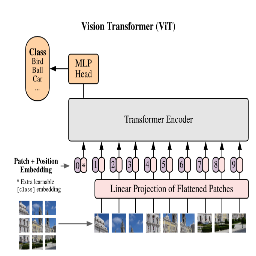

In [154]:
img_paths = ['./ln_in_vit.png',
            './transformer_encoder.png',
            './vit.png']
images = []

for img_path in img_paths:
    images.append(
        cv2.resize(cv2.imread(img_path)[:, :, ::-1],
                       (256, 256))
    )
    
Image.fromarray(images[2])

[0.8343288644030901, 0.8343288644030901, 1.0]


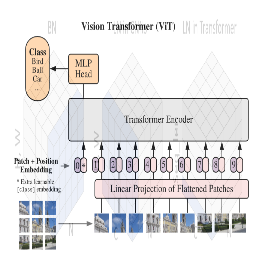

In [169]:
mixed_images, labels = mixup_data(images, [1, 0, 1], alpha=1)
print(labels)
Image.fromarray(mixed_images[2].astype(np.uint8))

Finally [CutMix](https://arxiv.org/pdf/1905.04899.pdf) is kind of a combination of mixup and cutout. It randomly selects a region of input image (like CutOut) and pastes a part of another image in this region. It makes input images less creapy than in MixUp and forces neural network to learn features that are more sensitive to local information.
<img src="https://miro.medium.com/max/318/1*STI1O9RPfEC9hsPXCHWSbg.png" style="width:50%">

#### RandAugment / AutoAugment

There is one more thing in augmentation created especially for lazy data scientists. Authors of [RandAugment](https://arxiv.org/pdf/1909.13719.pdf) suggested to collect all the powerful augmentations in one place and use only two parameter for tuning all of them simultaniously.

<img src="https://pbs.twimg.com/media/EJtAflaUUAAPLWv.png" style="width:50%">

Here is an example how different magnitude affects the final image.
<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-06_at_11.09.47_PM.png" style="width:50%">

The previous approach to build uber-augmentation tool on the basis of simple augmentation tools is called [AutoAugment](https://arxiv.org/abs/1805.09501). It is much more difficult approach comparing to RandAugment. In a nutshell it suggests to train RNN for sampling a better augmentation policy.
<img src="https://user-images.githubusercontent.com/26705935/61943777-27ad2980-afd7-11e9-8a16-d6d4a7ac192a.png" style="width:50%">

You still can find new papers which use AutoAugment in their experiments, but RandAugment is becoming a simple and effective replacement for AutoAugment.

### As a conclustion

Today there were a lot of lecture-like material and a small amount of real practice. But don't be upset. Your next homework will be about training ViT on CIFAR-10, so you will have opportunity to test all the stuff above. 

See you in homework 2-2!

## References

* [Attention is all you need](https://arxiv.org/abs/1706.03762) - original paper that introduces transformer architecture for NLP tasks.
* [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929) - paper that introduces Vision Transformers
* [How to train your ViT? Data, Augmentation,and Regularization in Vision Transformers](https://arxiv.org/pdf/2106.10270.pdf) - experiments on the importance of data augmentation and regularization
* [ViT on GitHub](https://github.com/google-research/vision_transformer) - original implementation of ViT
* [ViT on GitHub2](https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py) - good reimplementation in pytorch (`timm` library)
* [Improved Regularization of Convolutional Neural Networks with Cutout](https://arxiv.org/abs/1708.04552) - cutout 
* [mixup: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412) - mixup
* [CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features](https://arxiv.org/pdf/1905.04899.pdf) - CutMix
* [RandAugment: Practical automated data augmentationwith a reduced search space](https://arxiv.org/pdf/1909.13719.pdf) - RandAugment
* [SGDR: Stochastic Gradient Descent with Warm Restarts](https://arxiv.org/abs/1608.03983v5) - cosine annealing learning rate